In [13]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import time
from statistics import pstdev
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GroupKFold

In [14]:
h5 = h5py.File('data/SG24_dataset.h5')

In [15]:
predictors = np.asarray(h5['Predictors'])
pred = pd.DataFrame(predictors)

In [16]:
target = np.asarray(h5['Target'])
tar = pd.DataFrame(target[0])

In [17]:
users = np.asarray(h5['User'])
user = pd.DataFrame(users[0])

In [18]:
predictors = predictors[3:]
normalized_predictors = (predictors - np.mean(predictors, axis = 0))/ np.std(predictors, axis = 0)
final_predictors = normalized_predictors.transpose()
target = target[0]
print(final_predictors.shape)
print(target.shape)

(2400, 26)
(2400,)


# train users cross validated / test user

In [19]:
def split_test_by_user(predictors, target, users, test_user):
    train_indexes = [i for i in range(len(users)) if users[i] != test_user]
    test_indexes = [i for i in range(len(users)) if users[i] == test_user]
    X_train = [predictors[i] for i in train_indexes]
    X_test = [predictors[i] for i in test_indexes]
    y_train = [target[i] for i in train_indexes]
    y_test = [target[i] for i in test_indexes]
    user_train = [users[i] for i in train_indexes]
    user_test = [users[i] for i in test_indexes]
    
    return np.array(X_train), np.array(y_train), np.array(user_train), np.array(X_test), np.array(y_test), np.array(user_test)
    

In [20]:
TEST_USER = 2
x_train, y_train, user_train, x_test, y_test, user_test = split_test_by_user(final_predictors, target, users[0], TEST_USER)

print(x_train.shape, y_train.shape, user_train.shape, x_test.shape, y_test.shape, user_test.shape)

(1800, 26) (1800,) (1800,) (600, 26) (600,) (600,)


### Random Forest

In [24]:
rf=RandomForestClassifier()
group_kfold = GroupKFold(n_splits=7)
iterator = group_kfold.split(x_train, y_train, user_train)  


pgrid = {'n_estimators': [210,220,230,250,260],
    'max_depth' : [15,16,17,18,19],
    'criterion' :['gini'],
    'random_state' :[0]}

grid_search = GridSearchCV(rf, param_grid=pgrid, cv=iterator, scoring='accuracy', verbose = 3)
grid_search.fit(x_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 7 folds for each of 25 candidates, totalling 175 fits
[CV 1/7] END criterion=gini, max_depth=15, n_estimators=210, random_state=0;, score=0.832 total time=   1.1s
[CV 2/7] END criterion=gini, max_depth=15, n_estimators=210, random_state=0;, score=0.903 total time=   1.2s
[CV 3/7] END criterion=gini, max_depth=15, n_estimators=210, random_state=0;, score=0.887 total time=   1.3s
[CV 4/7] END criterion=gini, max_depth=15, n_estimators=210, random_state=0;, score=0.883 total time=   1.3s
[CV 5/7] END criterion=gini, max_depth=15, n_estimators=210, random_state=0;, score=0.900 total time=   1.3s
[CV 6/7] END criterion=gini, max_depth=15, n_estimators=210, random_state=0;, score=0.867 total time=   1.4s
[CV 7/7] END criterion=gini, max_depth=15, n_estimators=210, random_state=0;, score=0.975 total time=   1.4s
[CV 1/7] END criterion=gini, max_depth=15, n_estimators=220, random_state=0;, score=0.833 total time=   1.1s
[CV 2/7] END criterion=gini, max_depth=15, n_estimators=220, rando

In [29]:
rf=RandomForestClassifier(criterion='log_loss', max_depth=16, max_features='auto', n_estimators=190, random_state=0)

start_time = time.time()
rf.fit(x_train, y_train)
print("train time : ",time.time() - start_time)

start_time = time.time()
yhat_rf=rf.predict(x_test)
print("test time : ",time.time() - start_time)

print("accuracy train : ",accuracy_score(y_train,rf.predict(x_train)))
print("accuracy test : ",accuracy_score(y_test,yhat_rf))

/home/manuel/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


train time :  3.018136739730835
test time :  0.033701181411743164
accuracy train :  1.0
accuracy test :  0.8733333333333333


### SVM

In [30]:
svc = svm.SVC()

group_kfold = GroupKFold(n_splits=7)
iterator = group_kfold.split(x_train, y_train, user_train)  

pgrid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear'],
              'random_state':[0],
              'probability':[True]} 

grid_search = GridSearchCV(svc, param_grid=pgrid, cv=iterator, scoring='accuracy', verbose = 3)
grid_search.fit(x_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 7 folds for each of 50 candidates, totalling 350 fits
[CV 1/7] END C=0.1, gamma=1, kernel=rbf, probability=True, random_state=0;, score=0.255 total time=   0.9s
[CV 2/7] END C=0.1, gamma=1, kernel=rbf, probability=True, random_state=0;, score=0.556 total time=   1.1s
[CV 3/7] END C=0.1, gamma=1, kernel=rbf, probability=True, random_state=0;, score=0.146 total time=   1.3s
[CV 4/7] END C=0.1, gamma=1, kernel=rbf, probability=True, random_state=0;, score=0.321 total time=   1.4s
[CV 5/7] END C=0.1, gamma=1, kernel=rbf, probability=True, random_state=0;, score=0.100 total time=   1.5s
[CV 6/7] END C=0.1, gamma=1, kernel=rbf, probability=True, random_state=0;, score=0.392 total time=   1.5s
[CV 7/7] END C=0.1, gamma=1, kernel=rbf, probability=True, random_state=0;, score=0.700 total time=   1.6s
[CV 1/7] END C=0.1, gamma=1, kernel=linear, probability=True, random_state=0;, score=0.795 total time=   0.2s
[CV 2/7] END C=0.1, gamma=1, kernel=linear, probability=True, random_state=0;, 

In [32]:
svc = svm.SVC(C= 32, gamma=0.03125, kernel= 'rbf', random_state=0, probability=True)

start_time = time.time()
svc.fit(x_train, y_train)
print("train time : ",time.time() - start_time)

start_time = time.time()
yhat_svc=svc.predict(x_test)
print("test time : ",time.time() - start_time)

print("accuracy train : ",accuracy_score(y_train,svc.predict(x_train)))
print("accuracy test : ",accuracy_score(y_test,yhat_svc))

train time :  0.4018263816833496
test time :  0.052852630615234375
accuracy train :  0.98
accuracy test :  0.91


### KNN

In [34]:
knn = KNeighborsClassifier()

group_kfold = GroupKFold(n_splits=7)
iterator = group_kfold.split(x_train, y_train, user_train)  

k_range = list(range(1, 31))
pgrid = dict(n_neighbors=k_range)

grid_search = GridSearchCV(knn, param_grid=pgrid, cv=iterator, scoring='accuracy')
grid_search.fit(x_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8598809523809524
{'n_neighbors': 7}


In [37]:
knn = KNeighborsClassifier(n_neighbors=7)

start_time = time.time()
knn.fit(x_train, y_train)
print("train time : ",time.time() - start_time)

start_time = time.time()
yhat_knn=knn.predict(x_test)
print("test time : ",time.time() - start_time)

print("accuracy train : ",accuracy_score(y_train,knn.predict(x_train)))
print("accuracy test : ",accuracy_score(y_test,yhat_knn))

train time :  0.0019807815551757812
test time :  0.33560776710510254
accuracy train :  0.9355555555555556
accuracy test :  0.905


### NB

In [38]:
nb = GaussianNB()

group_kfold = GroupKFold(n_splits=7)
iterator = group_kfold.split(x_train, y_train, user_train)  

pgrid = {'var_smoothing': np.logspace(0,-9, num=100)}

grid_search = GridSearchCV(nb, param_grid=pgrid, cv=7, scoring='accuracy')
grid_search.fit(x_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8795131662293005
{'var_smoothing': 0.02848035868435802}


In [42]:
nb = GaussianNB(var_smoothing=0.02848035868435802)

start_time = time.time()
nb.fit(x_train, y_train)
print("train time : ",time.time() - start_time)

start_time = time.time()
yhat_nb=nb.predict(x_test)
print("test time : ",time.time() - start_time)

print("accuracy train : ",accuracy_score(y_train,nb.predict(x_train)))
print("accuracy test : ",accuracy_score(y_test,yhat_nb))

train time :  0.00653839111328125
test time :  0.0038657188415527344
accuracy train :  0.9094444444444445
accuracy test :  0.87


### aléa

In [44]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(x_train, y_train)
yhat_dummy=dummy.predict(x_test)
print("accuracy test : ",accuracy_score(y_test,yhat_dummy))

accuracy test :  0.041666666666666664


### ROC

In [45]:
y_test_lb = label_binarize(y_test,classes=np.unique(target))

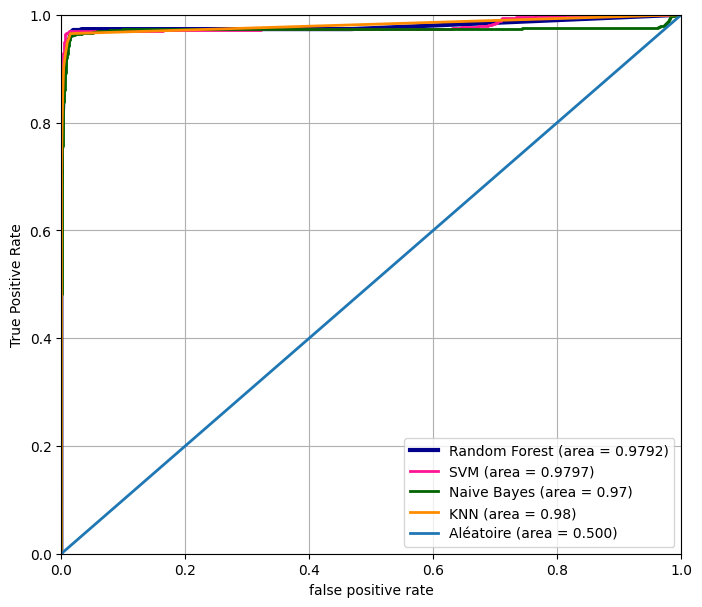

In [46]:
plt.figure(figsize=(8,7))

#random forest
pre_score = rf.predict_proba(x_test)
fpr_micro, tpr_micro, _ = roc_curve(y_test_lb.ravel(), pre_score.ravel())
AUC = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro,linewidth = 3,color="darkblue", label="Random Forest (area = {0:0.4f})".format(AUC))

#svm
pre_score = svc.predict_proba(x_test)
fpr_micro, tpr_micro, _ = roc_curve(y_test_lb.ravel(), pre_score.ravel())
AUC = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro,linewidth = 2,color="deeppink", label="SVM (area = {0:0.4f})".format(AUC))

#naive bayes
pre_score = nb.predict_proba(x_test)
fpr_micro, tpr_micro, _ = roc_curve(y_test_lb.ravel(), pre_score.ravel())
AUC = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro,linewidth = 2,color="darkgreen", label="Naive Bayes (area = {0:0.2f})".format(AUC))

#knn
pre_score = knn.predict_proba(x_test)
fpr_micro, tpr_micro, _ = roc_curve(y_test_lb.ravel(), pre_score.ravel())
AUC = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro,linewidth = 2,color="darkorange", label="KNN (area = {0:0.2f})".format(AUC))

#alea
pre_score = dummy.predict_proba(x_test)
fpr_micro, tpr_micro, _ = roc_curve(y_test_lb.ravel(), pre_score.ravel())
AUC = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro,linewidth = 2, label="Aléatoire (area = {0:0.3f})".format(AUC))

plt.xlabel ("false positive rate")
plt.ylabel ("True Positive Rate")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.legend(loc="lower right")
plt.show()




# train aléa / test 1 user

In [65]:
def experience_by_user(user):
    l=np.where(np.array(users[0]) == user)[0]
    x_train=[final_predictors[i] for i in range(len(final_predictors)) if i not in l]
    print("taille x_train : ",len(x_train))
    y_train=[target[i] for i in range(len(final_predictors)) if i not in l]
    x_test=[final_predictors[i] for i in l]
    print("taille x_test : ",len(x_test))
    y_test=[target[i] for i in l]
    
    print("\n----------------- Random Forest -----------------")
    rf_1=RandomForestClassifier(criterion='gini', max_depth=17, max_features='auto', n_estimators=230, random_state=0)
    start_time = time.time()
    rf_1.fit(x_train, y_train)
    print("train time : ",time.time() - start_time)
    start_time = time.time()
    yhat_rf=rf_1.predict(x_test)
    print("test time : ",time.time() - start_time)
    print("accuracy train : ",accuracy_score(y_train,rf_1.predict(x_train)))
    print("accuracy test : ",accuracy_score(y_test,yhat_rf))
    
    print("\n----------------- SVM -----------------")
    svc_1 = svm.SVC(C=1000, gamma=0.1, kernel='rbf', random_state=0, probability=True)
    start_time = time.time()
    svc_1.fit(x_train, y_train)
    print("train time : ",time.time() - start_time)
    start_time = time.time()
    yhat_svc=svc_1.predict(x_test)
    print("test time : ",time.time() - start_time)
    print("accuracy train : ",accuracy_score(y_train,svc_1.predict(x_train)))
    print("accuracy test : ",accuracy_score(y_test,yhat_svc))
    
    print("\n----------------- KNN -----------------")
    knn_1 = KNeighborsClassifier(n_neighbors=3)
    start_time = time.time()
    knn_1.fit(x_train, y_train)
    print("train time : ",time.time() - start_time)
    start_time = time.time()
    yhat_knn=knn_1.predict(x_test)
    print("test time : ",time.time() - start_time)
    print("accuracy train : ",accuracy_score(y_train,knn_1.predict(x_train)))
    print("accuracy test : ",accuracy_score(y_test,yhat_knn))
    
    print("\n----------------- NB -----------------")
    nb_1 = GaussianNB(var_smoothing=0.02310129700083159)
    start_time = time.time()
    nb_1.fit(x_train, y_train)
    print("train time : ",time.time() - start_time)
    start_time = time.time()
    yhat_nb=nb_1.predict(x_test)
    print("test time : ",time.time() - start_time)
    print("accuracy train : ",accuracy_score(y_train,nb_1.predict(x_train)))
    print("accuracy test : ",accuracy_score(y_test,yhat_nb))
    
    print("\n----------------- aléa -----------------")
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(x_train, y_train)
    yhat_dummy=dummy.predict(x_test)
    print("accuracy test : ",accuracy_score(y_test,yhat_dummy))
    
    print("\n----------------- ROC -----------------")
    y_test_lb = label_binarize(y_test,classes=np.unique(target))
    plt.figure(figsize=(8,7))

    #random forest
    pre_score = rf_1.predict_proba(x_test)
    fpr_micro, tpr_micro, _ = roc_curve(y_test_lb.ravel(), pre_score.ravel())
    AUC = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro,linewidth = 3,color="darkblue", label="Random Forest (area = {0:0.4f})".format(AUC))

    #svm
    pre_score = svc_1.predict_proba(x_test)
    fpr_micro, tpr_micro, _ = roc_curve(y_test_lb.ravel(), pre_score.ravel())
    AUC = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro,linewidth = 2,color="deeppink", label="SVM (area = {0:0.4f})".format(AUC))

    #naive bayes
    pre_score = nb_1.predict_proba(x_test)
    fpr_micro, tpr_micro, _ = roc_curve(y_test_lb.ravel(), pre_score.ravel())
    AUC = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro,linewidth = 2,color="darkgreen", label="Naive Bayes (area = {0:0.3f})".format(AUC))

    #knn
    pre_score = knn_1.predict_proba(x_test)
    fpr_micro, tpr_micro, _ = roc_curve(y_test_lb.ravel(), pre_score.ravel())
    AUC = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro,linewidth = 2,color="darkorange", label="KNN (area = {0:0.3f})".format(AUC))

    #alea
    pre_score = dummy.predict_proba(x_test)
    fpr_micro, tpr_micro, _ = roc_curve(y_test_lb.ravel(), pre_score.ravel())
    AUC = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro,linewidth = 2, label="Aléatoire (area = {0:0.3f})".format(AUC))

    plt.xlabel ("false positive rate")
    plt.ylabel ("True Positive Rate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid()
    plt.title("user "+str(user))
    plt.legend(loc="lower right")
    plt.show()

### User1 en test

taille x_train :  1800
taille x_test :  600

----------------- Random Forest -----------------
train time :  3.5940511226654053
test time :  0.10845112800598145
accuracy train :  1.0
accuracy test :  0.8366666666666667

----------------- SVM -----------------
train time :  1.0160400867462158
test time :  0.14883160591125488
accuracy train :  1.0
accuracy test :  0.83

----------------- KNN -----------------
train time :  0.0058176517486572266
test time :  0.10901761054992676
accuracy train :  0.9772222222222222
accuracy test :  0.8183333333333334

----------------- NB -----------------
train time :  0.008060216903686523
test time :  0.007486820220947266
accuracy train :  0.9327777777777778
accuracy test :  0.8316666666666667

----------------- aléa -----------------
accuracy test :  0.041666666666666664

----------------- ROC -----------------


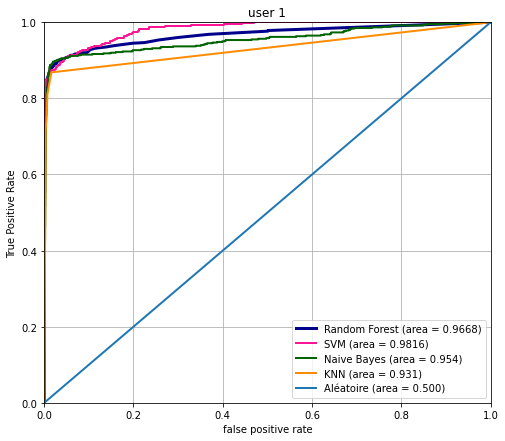

In [66]:
experience_by_user(1)

### User2 en test

taille x_train :  1800
taille x_test :  600

----------------- Random Forest -----------------
train time :  3.9634182453155518
test time :  0.1027383804321289
accuracy train :  1.0
accuracy test :  0.8633333333333333

----------------- SVM -----------------
train time :  1.183807134628296
test time :  0.19910025596618652
accuracy train :  1.0
accuracy test :  0.9083333333333333

----------------- KNN -----------------
train time :  0.0071582794189453125
test time :  0.09489297866821289
accuracy train :  0.96
accuracy test :  0.9

----------------- NB -----------------
train time :  0.008551836013793945
test time :  0.0102691650390625
accuracy train :  0.9088888888888889
accuracy test :  0.8683333333333333

----------------- aléa -----------------
accuracy test :  0.041666666666666664

----------------- ROC -----------------


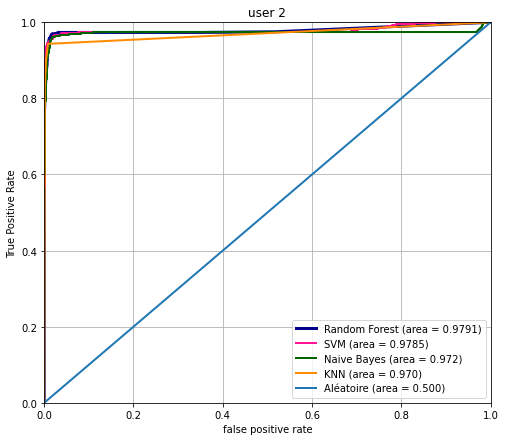

In [67]:
experience_by_user(2)

### User3 en test

taille x_train :  2040
taille x_test :  360

----------------- Random Forest -----------------
train time :  4.323763132095337
test time :  0.10278177261352539
accuracy train :  1.0
accuracy test :  0.9083333333333333

----------------- SVM -----------------
train time :  1.405688762664795
test time :  0.10095643997192383
accuracy train :  1.0
accuracy test :  0.8666666666666667

----------------- KNN -----------------
train time :  0.008446931838989258
test time :  0.05919218063354492
accuracy train :  0.9602941176470589
accuracy test :  0.8694444444444445

----------------- NB -----------------
train time :  0.009278297424316406
test time :  0.0009987354278564453
accuracy train :  0.9107843137254902
accuracy test :  0.8388888888888889

----------------- aléa -----------------
accuracy test :  0.041666666666666664

----------------- ROC -----------------


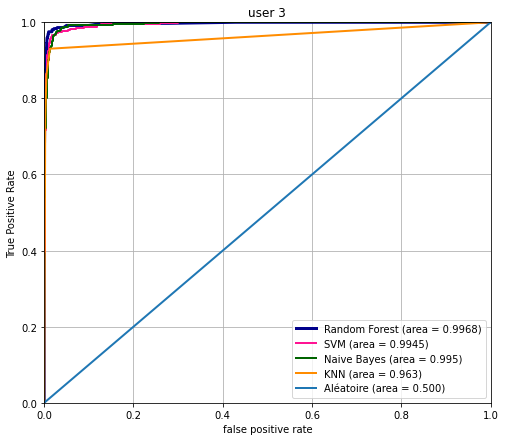

In [68]:
experience_by_user(3)

### User4 en test

taille x_train :  2160
taille x_test :  240

----------------- Random Forest -----------------
train time :  4.360140800476074
test time :  0.07474017143249512
accuracy train :  1.0
accuracy test :  0.9083333333333333

----------------- SVM -----------------
train time :  1.474980354309082
test time :  0.07692623138427734
accuracy train :  1.0
accuracy test :  0.8791666666666667

----------------- KNN -----------------
train time :  0.0
test time :  0.042287349700927734
accuracy train :  0.9625
accuracy test :  0.8541666666666666

----------------- NB -----------------
train time :  0.01701045036315918
test time :  0.0
accuracy train :  0.9092592592592592
accuracy test :  0.9125

----------------- aléa -----------------
accuracy test :  0.041666666666666664

----------------- ROC -----------------


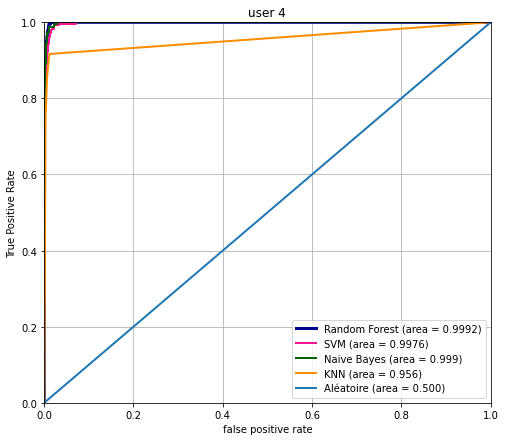

In [69]:
experience_by_user(4)

### User5 en test

taille x_train :  2160
taille x_test :  240

----------------- Random Forest -----------------
train time :  4.38059663772583
test time :  0.07482433319091797
accuracy train :  1.0
accuracy test :  0.8875

----------------- SVM -----------------
train time :  1.427022933959961
test time :  0.07285284996032715
accuracy train :  1.0
accuracy test :  0.8833333333333333

----------------- KNN -----------------
train time :  0.006554365158081055
test time :  0.048560380935668945
accuracy train :  0.9625
accuracy test :  0.7791666666666667

----------------- NB -----------------
train time :  0.008615493774414062
test time :  0.008431434631347656
accuracy train :  0.9092592592592592
accuracy test :  0.8458333333333333

----------------- aléa -----------------
accuracy test :  0.041666666666666664

----------------- ROC -----------------


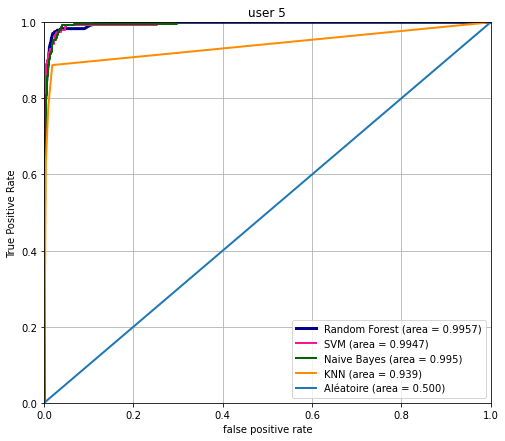

In [70]:
experience_by_user(5)

### User6 en test

taille x_train :  2280
taille x_test :  120

----------------- Random Forest -----------------
train time :  5.322556734085083
test time :  0.07525897026062012
accuracy train :  1.0
accuracy test :  0.9583333333333334

----------------- SVM -----------------
train time :  1.6109788417816162
test time :  0.03850555419921875
accuracy train :  1.0
accuracy test :  0.9083333333333333

----------------- KNN -----------------
train time :  0.002997159957885742
test time :  0.027240753173828125
accuracy train :  0.9618421052631579
accuracy test :  0.9333333333333333

----------------- NB -----------------
train time :  0.007584571838378906
test time :  0.008088827133178711
accuracy train :  0.9114035087719298
accuracy test :  0.9416666666666667

----------------- aléa -----------------
accuracy test :  0.041666666666666664

----------------- ROC -----------------


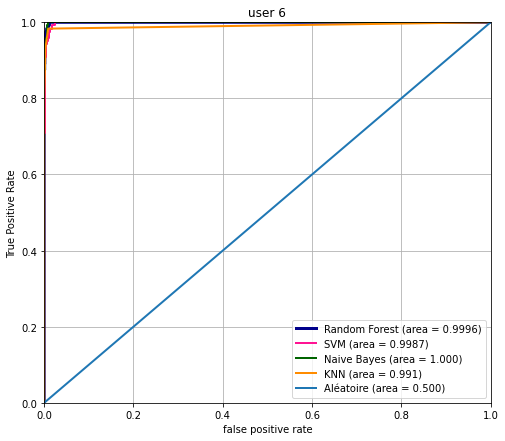

In [71]:
experience_by_user(6)

### User7 en test

taille x_train :  2280
taille x_test :  120

----------------- Random Forest -----------------
train time :  4.86759090423584
test time :  0.09812664985656738
accuracy train :  1.0
accuracy test :  0.9

----------------- SVM -----------------
train time :  1.902580976486206
test time :  0.0465548038482666
accuracy train :  1.0
accuracy test :  0.9

----------------- KNN -----------------
train time :  0.007467985153198242
test time :  0.023502826690673828
accuracy train :  0.9649122807017544
accuracy test :  0.9166666666666666

----------------- NB -----------------
train time :  0.00847935676574707
test time :  0.0063648223876953125
accuracy train :  0.9118421052631579
accuracy test :  0.8583333333333333

----------------- aléa -----------------
accuracy test :  0.041666666666666664

----------------- ROC -----------------


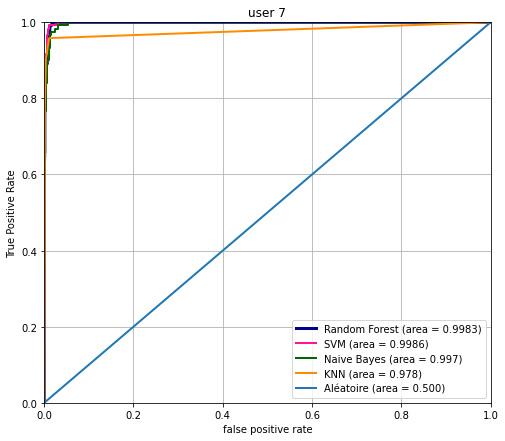

In [72]:
experience_by_user(7)

### User8 en test

taille x_train :  2280
taille x_test :  120

----------------- Random Forest -----------------
train time :  4.558915376663208
test time :  0.06473541259765625
accuracy train :  1.0
accuracy test :  0.875

----------------- SVM -----------------
train time :  1.567014217376709
test time :  0.040313720703125
accuracy train :  1.0
accuracy test :  0.8666666666666667

----------------- KNN -----------------
train time :  0.008358478546142578
test time :  0.016829252243041992
accuracy train :  0.9618421052631579
accuracy test :  0.8333333333333334

----------------- NB -----------------
train time :  0.00852656364440918
test time :  0.008095026016235352
accuracy train :  0.9122807017543859
accuracy test :  0.8166666666666667

----------------- aléa -----------------
accuracy test :  0.041666666666666664

----------------- ROC -----------------


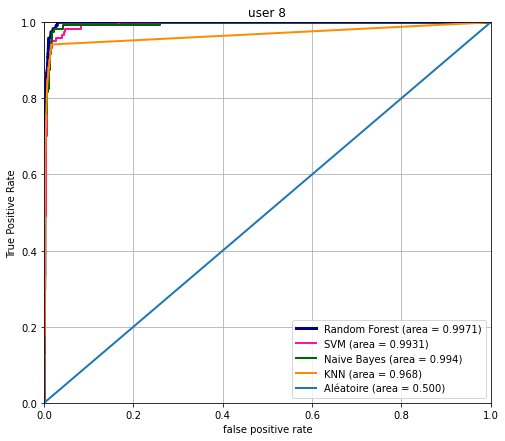

In [73]:
experience_by_user(8)

### Pour chaque user avec Random Forest


----------------- User  1  -----------------

----------------- User  2  -----------------

----------------- User  3  -----------------

----------------- User  4  -----------------

----------------- User  5  -----------------

----------------- User  6  -----------------

----------------- User  7  -----------------

----------------- User  8  -----------------


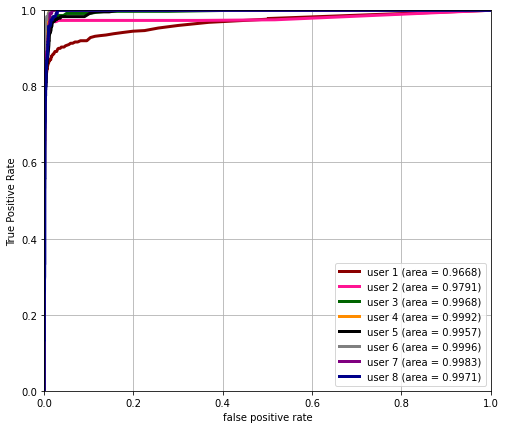

In [79]:
plt.figure(figsize=(8,7))
color=["darkred","deeppink","darkgreen","darkorange","black","grey","purple","darkblue"]

for user in range(1,9):
    print("\n----------------- User ",str(user)," -----------------")
    l=np.where(np.array(users[0]) == user)[0]
    x_train=[final_predictors[i] for i in range(len(final_predictors)) if i not in l]
    y_train=[target[i] for i in range(len(final_predictors)) if i not in l]
    x_test=[final_predictors[i] for i in l]
    y_test=[target[i] for i in l]
    rf=RandomForestClassifier(criterion='gini', max_depth=17, max_features='auto', n_estimators=230, random_state=0)
    start_time = time.time()
    rf.fit(x_train, y_train)
    y_test_lb = label_binarize(y_test,classes=np.unique(target))
    pre_score = rf.predict_proba(x_test)
    fpr_micro, tpr_micro, _ = roc_curve(y_test_lb.ravel(), pre_score.ravel())
    AUC = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro,linewidth = 3,color=color[user-1], label="user "+str(user)+" (area = {0:0.4f})".format(AUC))

plt.xlabel ("false positive rate")
plt.ylabel ("True Positive Rate")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.legend(loc="lower right")
plt.show()    